# DQN example

この例では，ChainerによるDQNの実装と，OpenAI Gymへの適用を行います．

In [1]:
import copy
import random
import collections

import gym
import numpy as np
import chainer
from chainer import functions as F
from chainer import links as L
from chainer import optimizers
%matplotlib notebook
import matplotlib.pyplot as plt

まずQ関数`Q(s,a)`を近似するニューラルネット`QFunction`を定義します．この例では入出力のインタフェースを次のようにします．

- 入力：状態表現 (`ndim_obs`次元のベクトル)
- 出力：各行動毎の価値 (`n_action`次元のベクトル)

この例では全結合層とReLUからなるニューラルネットを用います．Chainerでは，全結合層は`L.Linear`，ReLUは`F.relu`に当たります．3つの全結合層からなるニューラルネットを表現するために，複数の`Link`を組み合わせた`Link`をつくることができる`chianer.Chain`を継承してニューラルネットを次のように定義します．

In [2]:
class QFunction(chainer.Chain):

    def __init__(self, n_actions):
        initializer = chainer.initializers.HeNormal()
        c1 = 32
        c2 = 64
        c3 = 64
        fc_unit = 256

        super(QFunction, self).__init__(
             # the size of the inputs to each layer will be inferred
            conv1=L.Convolution2D(4, c1, 8, stride=4, pad=0),
            conv2=L.Convolution2D(c1, c2, 4, stride=2, pad=0),
            conv3=L.Convolution2D(c2, c3, 3, stride=1, pad=0),
            #conv4=L.Convolution2D(64, c4, 3, stride=1, pad=1),
            fc1=L.Linear(3136, fc_unit, initialW=initializer),
            fc2=L.Linear(fc_unit, n_actions, initialW=initializer),
            #bnorm1=L.BatchNormalization(c1),
            #bnorm2=L.BatchNormalization(c2),
            #bnorm3=L.BatchNormalization(c3),
            #bnorm4=L.BatchNormalization(c4),
        )

    def __call__(self, x):
        x = x/255.
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        #h = F.max_pooling_2d(F.relu(self.bnorm4(self.conv4(h))), 2, stride=2)
        h = F.relu(self.fc1(h))
        y = self.fc2(h)        
        return y

次に，アルゴリズムの実装に必要になる関数を実装していきます．

まず，先程定義した`QFunction`から，価値が最大になる行動のインデックスを計算する関数`get_greedy_action`を実装します．

- `Q.xp`は，`Q`がGPU上にあるかCPU上にあるかによって，それぞれ`cupy`，`numpy`のいずれかを表します．
- `chainer.no_backprop_mode`を使うと，Chainerはバックプロパゲーション用の計算グラフを構築せずに結果だけを計算するようになります．
- 多くのChainerの`Function`や`Link`（ここでは`Linear`）ではバッチ形式の入力が仮定されており，入力配列の1次元目がそのための次元に当たります．1つのデータ点だけについて計算を行いたい場合は，`(ndim_obs,) -> (1, ndim_obs)`のように次元を追加する必要があります．

In [3]:
def get_greedy_action(Q, obs):
    xp = Q.xp
    obs = xp.expand_dims(xp.asarray(obs, dtype=np.float32), 0)
    with chainer.no_backprop_mode():
        q = Q(obs).data[0]
    return int(xp.argmax(q))

次に，損失関数`mean_clipped_loss`を定義します．DQNでは学習の安定化のためにHuber損失を用います．Chainerの関数`F.huber_loss`は各データ点ごとにHuber損失を計算しますが，ここではさらにその平均を計算して損失とします．

In [4]:
def mean_clipped_loss(y, t):
    # Add an axis because F.huber_loss only accepts arrays with ndim >= 2
    y = F.expand_dims(y, axis=-1)
    t = F.expand_dims(t, axis=-1)
    return F.sum(F.huber_loss(y, t, 1.0)) / y.shape[0]

最後に，今実装した損失関数を使って，`QFunction`のパラメータを更新するための関数`update`を実装します．ここでは，DQNの更新式

$$Q(s,a) \leftarrow r + \gamma \max_b Q_{\text{target}}(s',b)$$

と，さらにそのバリエーションの1つであるDouble DQNの更新式

$$Q(s,a) \leftarrow r + \gamma Q_{\text{target}}(s',\text{argmax}_b Q(s',b)) $$

をバッチ形式で実装しています．`QFunction`の出力から特定のインデックスの行動の価値を取り出すには`F.select_item`を，最大価値を取り出すには`F.max`を，最大価値の行動のインデックスを計算するには`F.argmax`をそれぞれ使うことができます．

In [5]:
def update(Q, target_Q, opt, samples, gamma=0.99, target_type='double_dqn'): 
    xp = Q.xp
    s = np.ndarray(shape=(minibatch_size, STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT), dtype=np.float32)
    a = np.asarray([sample[1] for sample in samples], dtype=np.int32)
    r = np.asarray([sample[2] for sample in samples], dtype=np.float32)
    done = np.asarray([sample[3] for sample in samples], dtype=np.float32)
    s_next = np.ndarray(shape=(minibatch_size, STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT), dtype=np.float32)

    for i in xrange(minibatch_size):
        s[i] = samples[i][0]
        s_next[i] = samples[i][4]

    # to gpu if available
    s = xp.asarray(s)
    a = xp.asarray(a)
    r = xp.asarray(r)
    done = xp.asarray(done)
    s_next = xp.asarray(s_next)
    
    # Prediction: Q(s,a)
    y = F.select_item(Q(s), a)
    # Target: r + gamma * max Q_b (s',b)
    with chainer.no_backprop_mode():
        if target_type == 'dqn':
            t = xp.sign(r) + gamma * (1 - done) * F.max(target_Q(s_next), axis=1)
        elif target_type == 'double_dqn':
            t = xp.sign(r) + gamma * (1 - done) * F.select_item(
                target_Q(s_next), F.argmax(Q(s_next), axis=1))
        else:
            raise ValueError('Unsupported target_type: {}'.format(target_type))
    loss = mean_clipped_loss(y, t)
    Q.cleargrads()
    loss.backward()
    opt.update()

In [6]:
def meanQvalue(Q, samples): 
    xp = Q.xp
    s = np.ndarray(shape=(minibatch_size, STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT), dtype=np.float32)
    a = np.asarray([sample[1] for sample in samples], dtype=np.int32)

    for i in xrange(minibatch_size):
        s[i] = samples[i][0]

    # to gpu if available
    s = xp.asarray(s)
    a = xp.asarray(a)

    # Prediction: Q(s,a)
    y = F.select_item(Q(s), a)
    mean_Q = (F.sum(y)/minibatch_size).data
    return mean_Q
  

# 入力画像をStateへ変換

In [7]:
STATE_LENGTH = 4  # Number of most recent frames to produce the input to the network
FRAME_WIDTH = 84  # Resized frame width
FRAME_HEIGHT = 84  # Resized frame height
import numpy as np
from skimage.color import rgb2gray
from skimage.transform import resize

class ObsProcesser:
    def __init__(self):
        self.state = None
        
    def init_state(self, obs):
        processed_obs = self._preprocess_observation(obs)
        state = [processed_obs for _ in xrange(STATE_LENGTH)]
        self.state = np.stack(state, axis=0)
        
    def obs2state(self, obs):
        processed_obs = self._preprocess_observation(obs)
        self.state = np.concatenate((self.state[1:, :, :], processed_obs[np.newaxis]), axis=0)
        return self.state
    
    def _preprocess_observation(self, obs):
        # clop center
        return np.asarray(resize(rgb2gray(obs), (110, 84))[-84:, :]*255, dtype=np.uint8)

ここまでで必要な関数の実装は終わりました．以下ではアルゴリズムの全体を記述していきます．

In [8]:
# Hyperparameters
# env_name = 'CartPole-v0'  # env to play
env_name = 'Breakout-v0'  # env to play
# env_name = 'Pong-v0'  # env to play
#env_name = 'MsPacman-v0'  # env to play
#env_name = 'SpaceInvaders-v0'  # env to play


M = 100000  # number of episodes
replay_start_size = 50000  # steps after which we start to update
steps_to_decay_epsilon = 1000000  # steps to take to decay epsilon
min_epsilon = 0.1  # minimum value of epsilon
sync_interval = 10000  # interval of target sync
evaluation_interval = 50000
update_inverval = 4
minibatch_size = 32  # size of minibatch
reward_scale = 1  # scale factor for rewards
gpu = 0  # gpu id (-1 to use cpu)
render = False  # open a rendering window (will not work without display)
target_type = 'dqn'  # 'dqn' or 'double_dqn'
NO_OP_MAX = 12 # maximum number of "do nothing" actions at the start of an episode
save_model_inverval = 250000 # interval of save weights

# Initialize an environment
env = gym.make(env_name)
ndim_obs = env.observation_space.low.size
n_actions = env.action_space.n

# Initialize variables
D = collections.deque(maxlen=10 ** 6)  # replay memory: original 10 ** 6
Rs = []  # past returns
average_Rs = []
eval_Rs = [] # evaluation Max reward
eval_steps = [] # evaluation Max
step = 0  # total steps taken
episode = 0

# 
obs_processer = ObsProcesser()

[2017-01-13 12:56:02,790] Making new env: Breakout-v0


`QFunction`のインスタンス`Q`を作成し，GPUを使用する場合はそのための設定をします．さらに`Optimizer`（ここではAdamを使用します）のインスタンス`opt`に`Q`を渡すことで，`opt`が`Q`のパラメータを更新できるようにします．

DQNではパラメータを更新していくモデルとは別に，更新の際に目標値の計算にのみ使用するモデルを使用します．このモデルはChainerの`Optimizer`による更新は行わず，代わりに定期的にパラメータをコピーすることで同期を取ります．ここでは`copy.deepcopy`によりコピーを作ります．

In [9]:
# https://github.com/matthiasplappert/keras-rl/blob/master/examples/dqn_atari.py
# We patch the environment to be closer to what Mnih et al. actually do: The environment
# repeats the action 4 times
def _step(a):
    reward = 0.0
    action = env._action_set[a]
    for _ in range(4):
        reward += env.ale.act(action)
    ob = env._get_obs()
    done = env.ale.game_over()
    return ob, reward, done, {}
env._step = _step

In [10]:
# Initialize chainer models
Q = QFunction(n_actions)
if gpu >= 0:
    chainer.cuda.get_device(gpu).use()
    Q.to_gpu(gpu)
target_Q = copy.deepcopy(Q)
opt = optimizers.RMSpropGraves(lr=0.00025, alpha=0.95, momentum=0.95, eps=0.0001)
opt.setup(Q)

In [11]:
#chainer.serializers.load_hdf5("paper_dqn-Q.h5", Q)

以下がアルゴリズムの本体にあたります．環境とのインタラクションのループを回しつつ，経験をreplay memoryに蓄積していき，そこからのサンプルにより`Q`を更新していきます．環境とのインタラクションの際には，行動を$\epsilon$-greedyに従って選び，その$\epsilon$はステップが進むたびに減衰させていきます．

可視化のために各エピソードごとのスコア（報酬の和）を記録しプロットおり，学習の進行度合いを確認することができます．参考までに，CartPole-v0の最大スコアは200です．

<IPython.core.display.Javascript object>


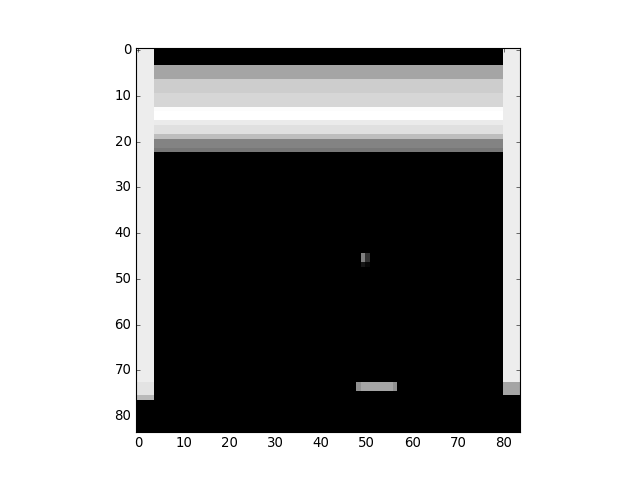

In [12]:
# show state
obs = env.reset()
obs_processer.init_state(obs)
for i in xrange(7):
    a = env.action_space.sample()
    obs, r, done, _ = env.step(a)
    obs_processer.obs2state(obs)
state = obs_processer.state
plt.imshow(state[0], cmap='gray', interpolation='nearest')

In [13]:
def Evaluation(render_flag = True, epsilon = 0.05):
    render = render_flag  # open a rendering window (will not work without display)
    Rs_eval = []  # past returns
    for episode in range(3):

        obs = env.reset()
        for _ in range(random.randint(1, NO_OP_MAX)):
            obs, _, _, _ = env.step(0)  # Do nothing
        obs_processer.init_state(obs)
        done = False
        R = 0.0
        t = 0
        limit = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')
        state = obs_processer.state

        while not done and t < limit:
            # Select an action
            if np.random.rand() < epsilon:
                a = env.action_space.sample()
            else:
                a = get_greedy_action(Q, state)

            # Execute an action
            new_obs, r, done, _ = env.step(a)

            new_state = obs_processer.obs2state(new_obs)

            if render:
                env.render()
            R += r

            state = new_state           

            t += 1

        print('Evaluation : episode: {} step: {} R:{}'.format(episode, step, R))
        Rs_eval.append(R)
    return Rs_eval

<IPython.core.display.Javascript object>


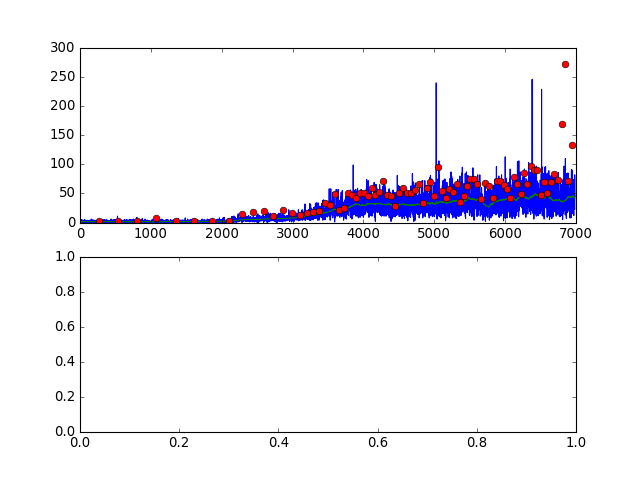

episode: 0 step: 175 R:1.0 average_R:1.0
episode: 20 step: 4188 R:3.0 average_R:1.95238095238
episode: 40 step: 7752 R:0.0 average_R:1.63414634146
episode: 60 step: 11539 R:1.0 average_R:1.62295081967
episode: 80 step: 15154 R:2.0 average_R:1.58024691358
episode: 100 step: 18520 R:2.0 average_R:1.47
episode: 120 step: 22211 R:0.0 average_R:1.38
episode: 140 step: 25811 R:0.0 average_R:1.42
episode: 160 step: 29585 R:0.0 average_R:1.46
episode: 180 step: 32704 R:0.0 average_R:1.33
episode: 200 step: 36216 R:0.0 average_R:1.39
episode: 220 step: 40088 R:2.0 average_R:1.44
episode: 240 step: 44154 R:2.0 average_R:1.54
episode: 260 step: 47975 R:0.0 average_R:1.49
target Q update! mean Q value : 0.025946624577, epsilon:1.0
Evaluation : episode: 0 step: 50000 R:2.0
Evaluation : episode: 1 step: 50000 R:3.0
Evaluation : episode: 2 step: 50000 R:3.0
episode: 280 step: 51689 R:0.0 average_R:1.68
episode: 300 step: 55182 R:0.0 average_R:1.69
episode: 320 step: 59254 R:1.0 average_R:1.71
target 

In [ ]:
# Initialize a figure
fig, ax = plt.subplots(2,1)
render = False  # open a rendering window (will not work without display)

while episode < M:

    obs = env.reset()
    for _ in range(random.randint(1, NO_OP_MAX)):
        obs, _, _, _ = env.step(0)  # Do nothing
    obs_processer.init_state(obs)
    done = False
    R = 0.0
    t = 0
    limit = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')
    state = obs_processer.state
    
    while not done and t < limit:

        # Select an action
        epsilon = 1.0 if len(D) < replay_start_size else \
            max(min_epsilon, np.interp(
                step, [replay_start_size, replay_start_size+steps_to_decay_epsilon], [1.0, min_epsilon]))
        if np.random.rand() < epsilon:
            a = env.action_space.sample()
        else:
            a = get_greedy_action(Q, state)

        # Execute an action
        new_obs, r, done, _ = env.step(a)
            
        new_state = obs_processer.obs2state(new_obs)
        
        if render:
            env.render()
        R += r

        # Store a transition
        D.append((state, a, r * reward_scale, done, new_state))
        state = new_state

        # Sample a random minibatch of transitions
        if len(D) >= replay_start_size:
            if step % update_inverval == 0:
                samples = random.sample(D, minibatch_size)
                update(Q, target_Q, opt, samples, target_type=target_type)
            
            if step % sync_interval == 0:
                mean_Q = meanQvalue(Q, samples)
                print('target Q update! mean Q value : {}, epsilon:{}'.format(mean_Q, epsilon))
                
            if step % evaluation_interval == 0:
                R_eval = Evaluation(render_flag=False)
                eval_Rs.append(max(R_eval))
                eval_steps.append(episode)
                
            if step % save_model_inverval == 0:
                save_model_filename = "paper_dqn_{}_{}.h5".format(env_name, step)
                print('save model : {}'.format(save_model_filename))
                chainer.serializers.save_hdf5(save_model_filename, Q)

        if step % sync_interval == 0:
            target_Q = copy.deepcopy(Q)

        step += 1
        t += 1
        

    Rs.append(R)
    average_R = np.mean(Rs[-100:])
    average_Rs.append(average_R)
    if episode % 20 is 0:
        print('episode: {} step: {} R:{} average_R:{}'.format(
              episode, step, R, average_R))
        
#     for i, it in enumerate([Rs, average_Rs]):
#         ax[i].clear()
#         ax[i].plot(it)
    ax[0].clear()
    ax[0].plot(Rs)
    ax[0].plot(average_Rs)
    ax[0].plot(eval_steps, eval_Rs, "o")
    fig.canvas.draw()
    episode += 1

In [ ]:
# save model 
chainer.serializers.save_hdf5("paper_dqn_mini32_update_interval_4-Q.h5", Q)

In [ ]:
# evaluation
Evaluation(True, 0.05)

<IPython.core.display.Javascript object>


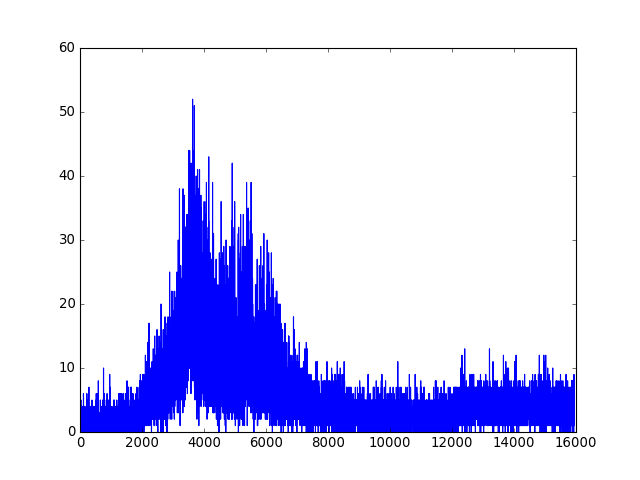

episode: 0 step: 236 R:3.0 average_R:3.0
episode: 10 step: 2057 R:2.0 average_R:1.54545454545
episode: 20 step: 4109 R:0.0 average_R:1.85714285714
episode: 30 step: 6005 R:2.0 average_R:1.77419354839
episode: 40 step: 7764 R:0.0 average_R:1.65853658537
episode: 50 step: 9878 R:0.0 average_R:1.72549019608
episode: 60 step: 11349 R:1.0 average_R:1.54098360656
episode: 70 step: 13131 R:0.0 average_R:1.50704225352
episode: 80 step: 14717 R:1.0 average_R:1.43209876543
episode: 90 step: 16696 R:1.0 average_R:1.46153846154
episode: 100 step: 18538 R:1.0 average_R:1.45
episode: 110 step: 20357 R:3.0 average_R:1.46
episode: 120 step: 22722 R:0.0 average_R:1.51
episode: 130 step: 24540 R:2.0 average_R:1.48
episode: 140 step: 26542 R:0.0 average_R:1.53
episode: 150 step: 28579 R:2.0 average_R:1.52
episode: 160 step: 30446 R:2.0 average_R:1.62
episode: 170 step: 32047 R:0.0 average_R:1.57
episode: 180 step: 33876 R:2.0 average_R:1.62
episode: 190 step: 35920 R:3.0 average_R:1.65
episode: 200 step:

KeyboardInterrupt: 

In [14]:
# Initialize a figure
fig, ax = plt.subplots(1,1)
render = False  # open a rendering window (will not work without display)

for episode in range(M):

    obs = env.reset()

    obs_processer.init_state(obs)
    done = False
    R = 0.0
    t = 0
    limit = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')
    state = obs_processer.state
    
    while not done and t < limit:

        # Select an action
        epsilon = 1.0 if len(D) < replay_start_size else \
            max(min_epsilon, np.interp(
                step, [replay_start_size, replay_start_size+steps_to_decay_epsilon], [1.0, min_epsilon]))
        if np.random.rand() < epsilon:
            a = env.action_space.sample()
        else:
            a = get_greedy_action(Q, state)

        # Execute an action
        new_obs, r, done, _ = env.step(a)
            
        new_state = obs_processer.obs2state(new_obs)
        
        if render:
            env.render()
        R += r

        # Store a transition
        D.append((state, a, r * reward_scale, done, new_state))
        state = new_state

        # Sample a random minibatch of transitions
        if len(D) >= replay_start_size:
            if step % update_inverval == 0:
                samples = random.sample(D, minibatch_size)
                update(Q, target_Q, opt, samples, target_type=target_type)
            
            if step % sync_interval == 0:
                mean_Q = meanQvalue(Q, samples)
                print('target Q update! mean Q value : {}, epsilon:{}'.format(mean_Q, epsilon))
                
            if step % evaluation_interval == 0:
                Evaluation(render_flag=False)

        if step % sync_interval == 0:
            target_Q = copy.deepcopy(Q)

        step += 1
        t += 1

    Rs.append(R)
    average_R = np.mean(Rs[-100:])
    if episode % 10 is 0:
        print('episode: {} step: {} R:{} average_R:{}'.format(
              episode, step, R, average_R))
    ax.clear()
    ax.plot(Rs)
    fig.canvas.draw()

# Save model

In [15]:
chainer.serializers.save_hdf5("paper_dqn_mini32_update_interval_4-Q.h5", Q)

# Evaluate

In [16]:
Evaluation(True, 0.05)

Evaluation : episode: 0 step: 4856019 R:2.0
Evaluation : episode: 1 step: 4856019 R:3.0
Evaluation : episode: 2 step: 4856019 R:0.0


In [27]:
w0

array([[ 0.80326307,  0.08314552,  2.52016759,  3.66371155,  5.14716864,
         4.1341753 ,  3.05793452,  2.01591277],
       [-1.10352862, -2.09547186,  1.81667984,  1.94813371,  1.08274245,
         0.692707  ,  3.14498591,  2.74038744],
       [-1.75998127, -1.18341374, -0.45962799, -0.22758859, -0.0787365 ,
         0.06948632,  0.34651443,  1.44045699],
       [-2.06538606, -2.64298368, -2.19102907, -1.57070518, -0.38253376,
        -0.09503935, -0.47910371, -1.12783086],
       [ 0.19295023,  0.52774245, -0.9823699 , -1.33720326,  0.67277968,
         0.06454331, -2.27162671, -1.51518714],
       [-1.51742887, -1.60922813,  1.80177891,  0.94318098, -1.28096831,
        -0.72204685,  0.07663451,  0.31119198],
       [-1.06289935, -1.97455323, -1.35045457, -1.07641649,  0.19957557,
        -2.81084538, -2.80089879, -0.8407985 ],
       [ 0.38097346, -1.2645663 ,  0.27745098, -0.52646083,  0.96398109,
         0.12806229, -0.83059657, -0.79354542]], dtype=float32)

In [31]:
w0.shape

(8, 8)

<IPython.core.display.Javascript object>


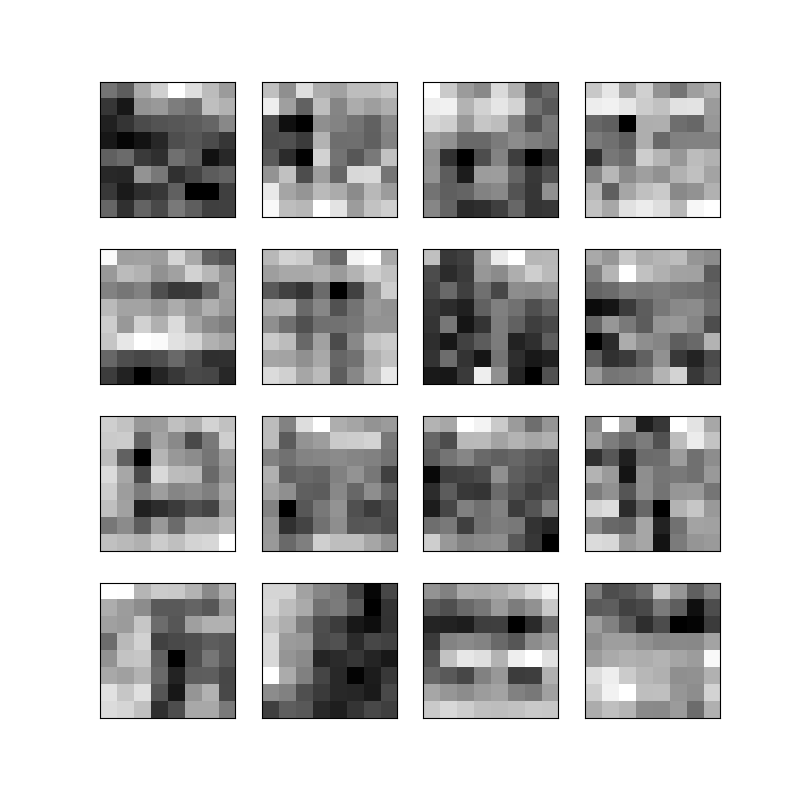

In [30]:
fig = plt.figure(figsize=(10, 10))
for i in xrange(16):
    w0 = chainer.cuda.to_cpu(Q.conv1.W.data[i,0,:])
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(w0, cmap='gray', interpolation='nearest')

In [ ]:
_w0 = deprocess(w0)
fig = plt.figure(figsize=(10, 10))
for i in xrange(49):
    ax = fig.add_subplot(7, 7, i + 1, xticks=[], yticks=[])
    ax.imshow(_w0[i])

In [18]:
a = get_greedy_action(Q, state)

InvalidType: 
Invalid operation is performed in: LinearFunction (Forward)

Expect: prod(in_types[0].shape[1:]) == in_types[1].shape[1]
Actual: 2592 != 10

In [9]:
%load_ext snakeviz

<IPython.core.display.Javascript object>


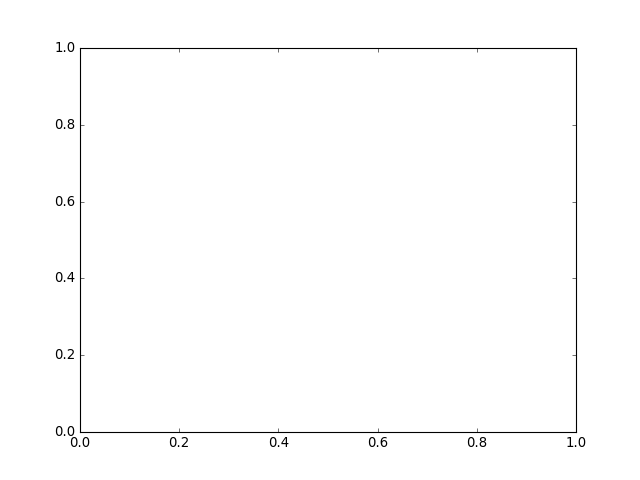

episode: 0 step: 843 R:310.0 average_R:310.0
episode: 1 step: 1380 R:290.0 average_R:300.0
episode: 2 step: 2048 R:210.0 average_R:270.0
episode: 3 step: 2727 R:190.0 average_R:250.0
episode: 4 step: 3320 R:210.0 average_R:242.0
episode: 5 step: 3914 R:270.0 average_R:246.666666667
episode: 6 step: 4508 R:250.0 average_R:247.142857143
episode: 7 step: 5047 R:130.0 average_R:232.5
episode: 8 step: 5731 R:240.0 average_R:233.333333333
episode: 9 step: 6279 R:170.0 average_R:227.0
 
*** Profile stats marshalled to file u'/tmp/komatsu/tmpINL6X2'. 


In [10]:
%%snakeviz
# Initialize a figure
fig, ax = plt.subplots(1,1)
render = False  # open a rendering window (will not work without display)

for episode in range(10):

    obs = env.reset()
    obs_processer.init_state(obs)
    done = False
    R = 0.0
    t = 0
    limit = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')
    state = obs_processer.state
    
    while not done and t < limit:

        # Select an action
        epsilon = 1.0 if len(D) < replay_start_size else \
            max(min_epsilon, np.interp(
                step, [0, steps_to_decay_epsilon], [1.0, min_epsilon]))
        if np.random.rand() < epsilon:
            a = env.action_space.sample()
        else:
            a = get_greedy_action(Q, state)

        # Execute an action
        new_obs, r, done, _ = env.step(a)
        
        new_state = obs_processer.obs2state(new_obs)
        
        if render:
            env.render()
        R += r

        # Store a transition
        D.append((state, a, r * reward_scale, done, new_state))
        state = new_state

        # Sample a random minibatch of transitions
        if len(D) >= replay_start_size:
            samples = random.sample(D, minibatch_size)
            update(Q, target_Q, opt, samples, target_type=target_type)

        if step % sync_interval == 0:
            target_Q = copy.deepcopy(Q)

        step += 1
        t += 1

    Rs.append(R)
    average_R = np.mean(Rs[-100:])
    print('episode: {} step: {} R:{} average_R:{}'.format(
          episode, step, R, average_R))

In [16]:
!snakeviz -s -p 8899 -H 192.168.102.161 /tmp/komatsu/tmpINL6X2

Port 8899 in use, trying another.
Port 8900 in use, trying another.
snakeviz web server started on 192.168.102.161:8901; enter Ctrl-C to exit
http://192.168.102.161:8901/snakeviz/%2Ftmp%2Fkomatsu%2FtmpINL6X2
^C
Bye!



In [17]:
%%snakeviz
# Select an action
epsilon = 1.0 if len(D) < replay_start_size else \
    max(min_epsilon, np.interp(
        step, [0, steps_to_decay_epsilon], [1.0, min_epsilon]))
if np.random.rand() < epsilon:
    a = env.action_space.sample()
else:
    a = get_greedy_action(Q, state)

# Execute an action
new_obs, r, done, _ = env.step(a)

new_state = obs_processer.obs2state(new_obs)

if render:
    env.render()
R += r

# Store a transition
D.append((state, a, r * reward_scale, done, new_state))
state = new_state

# Sample a random minibatch of transitions
if len(D) >= replay_start_size:
    samples = random.sample(D, minibatch_size)
    update(Q, target_Q, opt, samples, target_type=target_type)

if step % sync_interval == 0:
    target_Q = copy.deepcopy(Q)

step += 1
t += 1

 
*** Profile stats marshalled to file u'/tmp/komatsu/tmpjyvgKe'. 


In [18]:
%%time
# Select an action
epsilon = 1.0 if len(D) < replay_start_size else \
    max(min_epsilon, np.interp(
        step, [0, steps_to_decay_epsilon], [1.0, min_epsilon]))
if np.random.rand() < epsilon:
    a = env.action_space.sample()
else:
    a = get_greedy_action(Q, state)

# Execute an action
new_obs, r, done, _ = env.step(a)

new_state = obs_processer.obs2state(new_obs)

if render:
    env.render()
R += r

# Store a transition
D.append((state, a, r * reward_scale, done, new_state))
state = new_state

# Sample a random minibatch of transitions
if len(D) >= replay_start_size:
    samples = random.sample(D, minibatch_size)
    update(Q, target_Q, opt, samples, target_type=target_type)

if step % sync_interval == 0:
    target_Q = copy.deepcopy(Q)

step += 1
t += 1

CPU times: user 14.3 ms, sys: 323 µs, total: 14.7 ms
Wall time: 14.5 ms


In [ ]:
# Initialize a figure
fig, ax = plt.subplots(1,1)
render = True  # open a rendering window (will not work without display)

for episode in range(M):

    obs = env.reset()
    obs_processer.init_state(obs)
    done = False
    R = 0.0
    t = 0
    limit = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')
    state = obs_processer.state
    
    while not done and t < limit:

        # Select an action
        epsilon = 1.0 if len(D) < replay_start_size else \
            max(min_epsilon, np.interp(
                step, [0, steps_to_decay_epsilon], [1.0, min_epsilon]))
        if np.random.rand() < epsilon:
            a = env.action_space.sample()
        else:
            a = get_greedy_action(Q, state)

        # Execute an action
        new_obs, r, done, _ = env.step(a)
        
        new_state = obs_processer.obs2state(new_obs)
        
        if render:
            env.render()
        R += r

        # Store a transition
        D.append((state, a, r * reward_scale, done, new_state))
        state = new_state

        # Sample a random minibatch of transitions
        if len(D) >= replay_start_size:
            samples = random.sample(D, minibatch_size)
            update(Q, target_Q, opt, samples, target_type=target_type)

        if step % sync_interval == 0:
            target_Q = copy.deepcopy(Q)

        step += 1
        t += 1

    Rs.append(R)
    average_R = np.mean(Rs[-100:])
    print('episode: {} step: {} R:{} average_R:{}'.format(
          episode, step, R, average_R))
    ax.clear()
    ax.plot(Rs)
    fig.canvas.draw()

In [14]:
a.shape

(64,)

In [18]:
r.shape

(64,)

In [19]:
done

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [15]:
xp = Q.xp
s = np.ndarray(shape=(minibatch_size, STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT), dtype=np.float32)
a = np.ndarray(shape=(minibatch_size), dtype=np.int32)
r = np.ndarray(shape=(minibatch_size), dtype=np.float32)
done = np.ndarray(shape=(minibatch_size), dtype=np.float32)
s_next = np.ndarray(shape=(minibatch_size, STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT), dtype=np.float32)

for i in xrange(minibatch_size):
    s[i] = samples[i][0]
    a[i] = samples[i][1]
    r[i] = samples[i][2]
    done[i] = samples[i][3]
    s_next[i] = samples[i][4]

# to gpu if available
s = xp.asarray(s, dtype=xp.float32)
s_next = xp.asarray(s_next, dtype=xp.float32)

In [16]:
a.shape

(64, 1)

In [56]:
%%timeit
xp = Q.xp
# Pack samples into arrays to enable batch computation
# s = xp.asarray([sample[0] for sample in samples], dtype=np.float32) # too slow
s = xp.stack([xp.asarray(sample[0], dtype=np.float32) for sample in samples], axis=0).astype(xp.float32)
a = xp.asarray([sample[1] for sample in samples], dtype=np.int32)
r = xp.asarray([sample[2] for sample in samples], dtype=np.float32)
done = xp.asarray([sample[3] for sample in samples], dtype=np.float32)
# s_next = xp.asarray([sample[4] for sample in samples], dtype=np.float32) # too slow
s_next = xp.stack([xp.asarray(sample[4], dtype=np.float32) for sample in samples], axis=0).astype(xp.float32)


10 loops, best of 3: 24.3 ms per loop


In [26]:
%%timeit
xp = Q.xp
s = np.ndarray(shape=(minibatch_size, STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT), dtype=np.float32)
a = np.ndarray(shape=(minibatch_size), dtype=np.int32)
r = np.ndarray(shape=(minibatch_size), dtype=np.float32)
done = np.ndarray(shape=(minibatch_size), dtype=np.float32)
s_next = np.ndarray(shape=(minibatch_size, STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT), dtype=np.float32)

for i in xrange(minibatch_size):
    s[i] = samples[i][0]
    a[i] = samples[i][1]
    r[i] = samples[i][2]
    done[i] = samples[i][3]
    s_next[i] = samples[i][4]

# to gpu if available
s = xp.asarray(s, dtype=xp.float32)
s_next = xp.asarray(s_next, dtype=xp.float32)

100 loops, best of 3: 5.72 ms per loop


In [ ]:
a = xp.asarray([sample[1] for sample in samples], dtype=np.int32)
r = xp.asarray([sample[2] for sample in samples], dtype=np.float32)
done = xp.asarray([sample[3] for sample in samples], dtype=np.float32)

In [28]:
%%timeit
xp = Q.xp
s = np.ndarray(shape=(minibatch_size, STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT), dtype=np.float32)
a = np.asarray([sample[1] for sample in samples], dtype=np.int32)
r = np.asarray([sample[2] for sample in samples], dtype=np.float32)
done = np.asarray([sample[3] for sample in samples], dtype=np.float32)
s_next = np.ndarray(shape=(minibatch_size, STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT), dtype=np.float32)

for i in xrange(minibatch_size):
    s[i] = samples[i][0]
    s_next[i] = samples[i][4]

# to gpu if available
s = xp.asarray(s)
a = xp.asarray(a)
r = xp.asarray(r)
done = xp.asarray(done)
s_next = xp.asarray(s_next)

100 loops, best of 3: 10.4 ms per loop


In [29]:
xp = Q.xp
s = np.ndarray(shape=(minibatch_size, STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT), dtype=np.float32)
a = np.asarray([sample[1] for sample in samples], dtype=np.int32)
r = np.asarray([sample[2] for sample in samples], dtype=np.float32)
done = np.asarray([sample[3] for sample in samples], dtype=np.float32)
s_next = np.ndarray(shape=(minibatch_size, STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT), dtype=np.float32)

for i in xrange(minibatch_size):
    s[i] = samples[i][0]
    s_next[i] = samples[i][4]

# to gpu if available
s = xp.asarray(s)
a = xp.asarray(a)
r = xp.asarray(r)
done = xp.asarray(done)
s_next = xp.asarray(s_next)

In [11]:
%load_ext snakeviz

In [33]:
%%snakeviz

obs = env.reset()
obs_processer.init_state(obs)
done = False
R = 0.0
t = 0
limit = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')
state = obs_processer.state

xp = Q.xp
gamma=0.99

s = np.ndarray(shape=(minibatch_size, STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT), dtype=np.float32)
a = np.asarray([sample[1] for sample in samples], dtype=np.int32)
r = np.asarray([sample[2] for sample in samples], dtype=np.float32)
done = np.asarray([sample[3] for sample in samples], dtype=np.float32)
s_next = np.ndarray(shape=(minibatch_size, STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT), dtype=np.float32)

for i in xrange(minibatch_size):
    s[i] = samples[i][0]
    s_next[i] = samples[i][4]

# to gpu if available
s = xp.asarray(s)
a = xp.asarray(a)
r = xp.asarray(r)
done = xp.asarray(done)
s_next = xp.asarray(s_next)

# Prediction: Q(s,a)
y = F.select_item(Q(s), a)
# Target: r + gamma * max Q_b (s',b)
with chainer.no_backprop_mode():
    if target_type == 'dqn':
        t = r + gamma * (1 - done) * F.max(target_Q(s_next), axis=1)
    elif target_type == 'double_dqn':
        t = r + gamma * (1 - done) * F.select_item(
            target_Q(s_next), F.argmax(Q(s_next), axis=1))
    else:
        raise ValueError('Unsupported target_type: {}'.format(target_type))
loss = mean_clipped_loss(y, t)
Q.cleargrads()
loss.backward()
opt.update()

 
*** Profile stats marshalled to file u'/tmp/komatsu/tmpl2ntJz'. 


## Exercise: Visualize the result

1) Access to the server via SSH

better to use local forward like;
    
    Host ilect.aws
    HOSTNAME xx.xx.xx.xx
    User ubuntu
    IdentityFile ~/.ssh/sshkey.txt
    LocalForward    8888    localhost:8888
 
2) execute following command

    $ snakeviz -s -p 8888 -H 0.0.0.0 /tmp/xxx
    (-s for server mode)
    
3) access via browser

    http://xx.xx.xx.xx:8888/...
    (or localhost:8888/...)
    
    
snakeviz -s -p 8899 -H 192.168.102.161 /tmp/komatsu/tmpQ3XGRj